In [1]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

In [12]:
def convert(img):
    anno_map = np.asarray(img)
    anno_map[anno_map == 4] = 4

    R = anno_map.copy()   # 红色通道
    R[R == 1] = 0
    R[R == 2] = 0
    R[R == 3] = 255

    G = anno_map.copy()   # 绿色通道
    G[G == 1] = 0
    G[G == 2] = 255
    G[G == 3] = 0

    B = anno_map.copy()   # 蓝色通道
    B[B == 1] = 255
    B[B == 2] = 0
    B[B == 3] = 0
    return np.dstack((R,G,B))

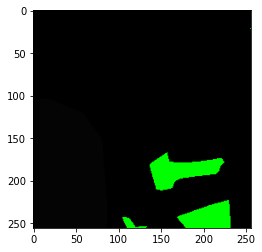

In [18]:
img_name = "image_11_1101.png"
img = os.path.join("dataset/tianchi/round2/label/", img_name)
img = Image.open(img).resize((256, 256), Image.NEAREST)
img = convert(img)
cv2.imwrite(img_name, img)
plt.imshow(img)